In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Load data
file_path = r"C:\Users\nycmb\OneDrive\Desktop\782\HB1.csv"
data = pd.read_csv(file_path)

# Normalize the case of the gender column to lowercase
data['gender'] = data['gender'].str.lower()

# Map gender to numeric
data['gender'] = data['gender'].map({'male': 0, 'female': 1})

# Convert location to numeric codes
data['location_code'] = data['location'].astype('category').cat.codes

# Encode age ranges to numeric categories (e.g., '18-24' -> 0, '25-34' -> 1, etc.)
data['age_code'] = data['age'].astype('category').cat.codes

# Check for missing values in gender and handle them without inplace operation
if data['gender'].isnull().sum() > 0:
    data['gender'] = data['gender'].fillna(data['gender'].mean())

# Define features and target variable
X = data[['age_code', 'gender', 'location_code', 'likelihood_percent']]
y = data['behavior']

# Handle missing values by imputing with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define logistic regression model with L2 regularization
model = LogisticRegression(penalty='l2', solver='liblinear')

# Perform 5-fold cross-validation on training data
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Function to predict likelihood
def predict_likelihood(age, gender, location, likelihood_percent):
    # Convert inputs to numeric values
    gender = 0 if gender == 'male' else 1
    
    # Get the original location string from the data
    location_categories = data['location'].astype('category').cat.categories.tolist()
    
    # Check if the provided location exists in the dataset
    if location in location_categories:
        location_code = location_categories.index(location)
    else:
        raise ValueError(f"Location '{location}' not found in dataset. Available locations are: {location_categories}")
    
    # Ensure correct age input
    age_categories = data['age'].astype('category').cat.categories.tolist()
    
    if age in age_categories:
        age_code = age_categories.index(age)
    else:
        raise ValueError(f"Age '{age}' not found in dataset. Available age groups are: {age_categories}")
    
    # Create a DataFrame with the input data to retain feature names
    input_data = pd.DataFrame([[age_code, gender, location_code, likelihood_percent]], columns=['age_code', 'gender', 'location_code', 'likelihood_percent'])
    
    # Impute and scale features
    scaled_features = scaler.transform(imputer.transform(input_data))
    
    # Get the probability
    likelihood = model.predict_proba(scaled_features)[0][1]
    return likelihood

# Example usage
age = '55-64'  # Age range as a string
gender = 'female'
location = 'Docklands'
likelihood_percent = 47.5  # Example likelihood percent from dataset

likelihood = predict_likelihood(age, gender, location, likelihood_percent)
print(f'Likelihood of Mental Health behavior for {age}-year-old {gender} in {location} with likelihood percent {likelihood_percent}: {likelihood:.2f}')


Cross-Validation Scores: [0.41666667 0.63636364 0.63636364 0.63636364 0.54545455]
Mean CV Score: 0.5742424242424242
Accuracy: 0.5
Classification Report:
                 precision    recall  f1-score   support

  Mental Health       0.67      0.57      0.62         7
Physical Health       0.50      0.67      0.57         6
        Smoking       0.40      0.33      0.36         6
         Vaping       0.40      0.40      0.40         5

       accuracy                           0.50        24
      macro avg       0.49      0.49      0.49        24
   weighted avg       0.50      0.50      0.50        24

Likelihood of Mental Health behavior for 55-64-year-old female in Docklands with likelihood percent 47.5: 0.39


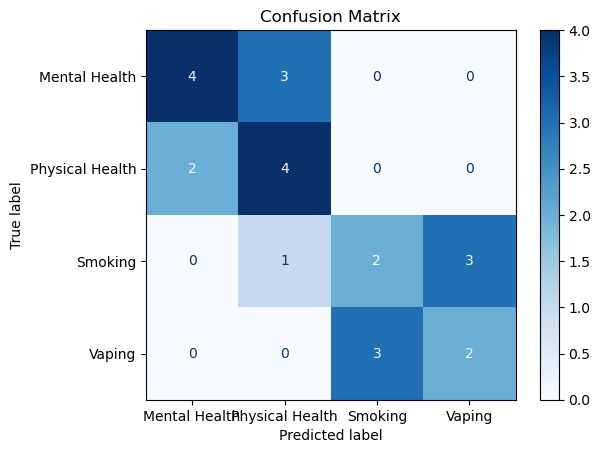

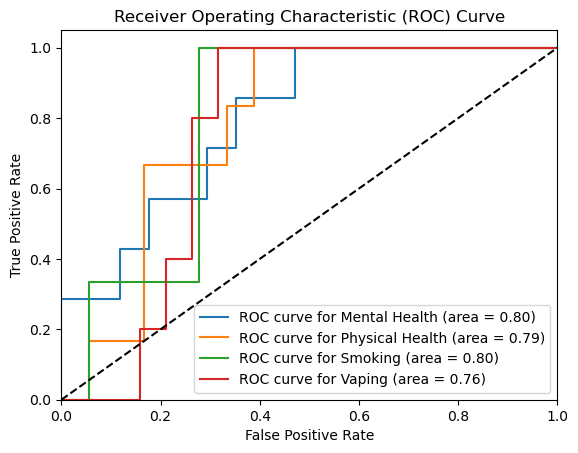

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# For ROC curve, you need to get probability estimates for each class
y_prob = model.predict_proba(X_test)

# Since this is a multiclass problem, we'll plot ROC curve for each class separately
for i, class_label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=class_label)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
